# Explaining The ML models - XAI (eXplainable AI)

Interpretation techniques for the ML models focus on analysis how the input features (or change in their values) affect the predictions. Many classic models exhibit 'built-in' high interpretability, but the predictions of the complex models such as neural networks are opaque (hence the often used name 'black-box' models). 

In the recent years, explainability of the ML models (black-box in particular) became a popular topic and fueled many novel algorithms - the trend is often referred to as **Interpretable Machine Learning** or **Explainable Artificial Intelligence (XAI)**. 

Based on the applicability, the interpretability techniques can be categorised as follows:
 - **model-specific (intrinsic)** - tied to particular class of models, inherently available by design of the given algorithm e.g., linear regression, logistic regression, decision trees
 - **model-agnostic** - applicable to all ML models, mostly based on modifying the input data and 'probing' the influence on model's predictions or model's quality

Additionally, the explainability algorithms may be broken down by the target they are applied to:
 - **prediction-level (local)** - provide explanation for prediction produced for a particular instance, useful if we want to understand the models behaviour on the per-case basis
 - **dataset-level (global)** - highlight overall feature influence on the model predictions

Every interpretability technique is characterized by both breakdowns, so we may have a model-specific global technique, model-agnostic local algorithm, etc. 

In [34]:
using CSV, DataFrames
using Random, Statistics
using ExplainableAI, ShapML
using ImageShow, Plots, FileIO
using GLM, Flux, XGBoost, Metalhead
using ProgressMeter

## Preparing the data

We'll use the dataset containing information about housing in the suburbs of Boston. You can find more information about the dataset in the [UCI repository](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/). Data is available for ingestion in the **Boston.csv** file in the directory of the notebook.

Attribute Information:

1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town
4. CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per \$10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - \% lower status of the population
14. MEDV - Median value of owner-occupied homes in \$1000's

Let's load the data into a `DataFrame` and inspect the first observation.

In [4]:
houses = CSV.read("Boston.csv", DataFrame)
first(houses)

Row,Column1,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
,Int64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0


The task is to predict the median house value (`medv`) based on all other available features. Let's remove the `Column1` containing observation ID and save the names of independent variables for further use.

In [5]:
select!(houses, Not(:Column1))
feature_names = names(houses, Not(:medv));

## Models training

Let's train three different models for the sake of interpretability analysis. Please note that we are not splitting the dataset into training, validation and test subsets as we are not picking the optimal specifications of the models.

 1. Linear Regression

In [6]:
lin_reg = lm(term(:medv) ~ sum(term.(feature_names)), houses);

 2. Gradient Boosted Trees

In [7]:
X = Matrix(houses[!, Not(:medv)])
y = houses.medv
xgb_reg = xgboost(X, 30, label = y, objective = "reg:squarederror", seed = 42);

[1]	train-rmse:17.05900715572495230
[2]	train-rmse:12.26368674723081753
[3]	train-rmse:8.93114637343270878
[4]	train-rmse:6.57216620112587702
[5]	train-rmse:4.90730769533286715
[6]	train-rmse:3.73352228325755009
[7]	train-rmse:2.91233734815793177
[8]	train-rmse:2.36294279877742719
[9]	train-rmse:1.95365120412843241
[10]	train-rmse:1.68486627623485652
[11]	train-rmse:1.52810247726425508
[12]	train-rmse:1.41097983072858990
[13]	train-rmse:1.30772235807096204
[14]	train-rmse:1.23004706020786947
[15]	train-rmse:1.12609603362943567
[16]	train-rmse:1.06440182268894690
[17]	train-rmse:1.03686868546994670
[18]	train-rmse:0.97260643733196372
[19]	train-rmse:0.90246849406120055
[20]	train-rmse:0.87343151328281221
[21]	train-rmse:0.84856277860450746
[22]	train-rmse:0.79534234737435439
[23]	train-rmse:0.77153987727182360
[24]	train-rmse:0.71861989409592208
[25]	train-rmse:0.69359044665873582
[26]	train-rmse:0.63975423805274600
[27]	train-rmse:0.61774749746373636
[28]	train-rmse:0.57560824223536700

3. Neural Network with one dense hidden layer with ReLU activation function

In [8]:
X_flux = transpose(X)
y_flux = transpose(y)
model = Chain(Dense(13 => 30, relu),  Dense(30 => 1))
loss(x, y) = Flux.Losses.mse(model(x), y)
parameters = Flux.params(model)
data = [(X_flux, y_flux)]
opt = Flux.Adam(0.005)
@showprogress for epoch in 1:30_000
    Flux.train!(loss, parameters, data, opt)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:152:17


We'll do a quick check of models predictive power on the training data. If the model fits poorly, the output of the interpretability algorithms is not representative and may lead to misleading conclusions. Let's use R² metric for the purpose of the test.

In [9]:
R2(y, ŷ) = round(sum((ŷ .- mean(y)).^2)/sum((y .- mean(y)).^2); digits = 2)

R2 (generic function with 1 method)

In [10]:
print("Linear regression R²: ", R2(y, GLM.predict(lin_reg, houses)),
"\nGradient boosted trees R²: ", R2(y, XGBoost.predict(xgb_reg, X)),
"\nNeural network R²: ", R2(y_flux, model(X_flux)))

Linear regression R²: 0.74
Gradient boosted trees R²: 0.98
Neural network R²: 0.94

R² is very high for the neural network and gradient boosted trees (>0.9). Linear regression scores much lower (~0.7), but is still high and intepretability results shouldn't be significantly distorted.

## Model-specific interpretability

**Linear Regression** and the **Gradient Boosted Trees** are example of the models with 'built-in' (**inherent**) explainability.

For the former, we can **directly interpret the values of the parameters** of the trained model - the approach is applicable to the whole family of [**Generalized Linear Models (GLMs)**](https://en.wikipedia.org/wiki/Generalized_linear_model) with appropiate transformations applied to the parameters and target variable values, e.g. logistic regression, Poisson regression.

**Gradient Boosted Trees** is part of the bigger family of **tree-based models** (which includes various Decision Tree algorithms and ensemble models such as Random Forest). For the tree-based models, we can calculate a **feature importance** - the metric of the features contribution to the model's predictive power. The parameter values are not analysed directly, instead we are extracting a statistic (nodes impurity decrease) from the training process, which is relevant to understanding the model's decisions.

### Linear regression

Calling the variable with trained linear regression model produces a summary of the coefficients for interpretation.

In [11]:
lin_reg

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

medv ~ 1 + crim + zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + black + lstat

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)   36.4595       5.10346       7.14    <1e-11   26.4322       46.4868
crim          -0.108011     0.032865     -3.29    0.0011   -0.172584     -0.0434383
zn             0.0464205    0.0137275     3.38    0.0008    0.0194488     0.0733921
indus          0.0205586    0.0614957     0.33    0.7383   -0.100268      0.141385
chas           2.68673      0.86158       3.12    0.0019    0.993904      4.37956
nox          -17.7666       3

We can directly interpret calculated coefficients as the change in the predicted value (median house value in thousands of dollars) for a unit change in the value of the feature.

For example, prediction of median house value will increase by 3 810 dollars with each additional room (`rm`) in the estate. 

### Gradient Boosted Trees

The `importance` function from the `XGBoost` package extracts features importance values from the given Gradient Boosted Trees model. Three importance measures are listed (Gain, Coverage and Frequency), but the most commonly used is Gain, which is the improvement in error reduction brought by a feature to the branches it is on. 

In [12]:
f_imp = importance(xgb_reg, feature_names)

13-element Vector{XGBoost.FeatureImportance}:
Gain      Coverage  Frequency  Feature
0.5419    0.1945    0.1143     lstat
0.3105    0.2028    0.1550     rm
0.0466    0.1524    0.1324     dis
0.0355    0.0777    0.2070     crim
0.0262    0.0461    0.0554     nox
0.0109    0.0481    0.0441     ptratio
0.0086    0.0556    0.0407     tax
0.0078    0.1117    0.1086     age
0.0064    0.0761    0.0803     black
0.0040    0.0123    0.0305     indus
0.0012    0.0192    0.0158     rad
0.0002    0.0013    0.0124     zn
0.0002    0.0022    0.0034     chas


Let's compare feature importance (Gain) of all variables on the barplot.

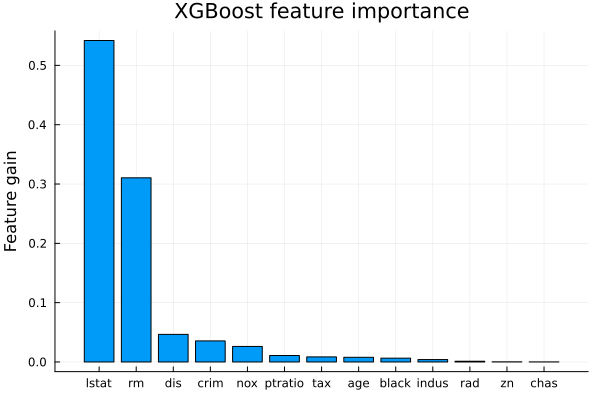

In [13]:
bar(getproperty.(f_imp, :fname), getproperty.(f_imp, :gain), 
    ylab = "Feature gain", legend = nothing, title = "XGBoost feature importance")

Based on the inherent feature importance two the most important features for the model predictions are `lstat` and `rm`. Note that the feature importance value doesn't indicate if the increase in the feature value corresponds to the increase in the target variable or otherwise.

## Model-agnostic interpretability

Model-agnostic algorithms may be applied on top of many Machine Learning models. The algorithms modify the input data and analyse the returned predictions - the inner architecture of the model is not relevant in that context. The model-agnostic techniques can be further divided into:

Global techniques (explaining overall features effect on predictions):
- [Partial Dependence Plots (PDP)](https://www.jstor.org/stable/2699986)
- [Accumulated Local Effects (ALE)](https://arxiv.org/abs/1612.08468)
- [Permutation-based feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html)

Local techniques (explaining particular prediction):
- [Individual Conditional Expectations (ICE)](https://arxiv.org/abs/1309.6392)
- [LIME (Local Interpretable Model-agnostic Explanations)](https://arxiv.org/abs/1602.04938)
- [Shapley Values and SHAP (SHapley Additive exPlanations)](https://arxiv.org/abs/1705.07874)

Let's explore one algorithm from each category: global **Permutation feature importance** and local **SHAP values**.

### Permutation-based feature importance

The technique relies on measuring effect of breaking the relation between independent features and target variable. The idea is quite straightforward - if the important feature is randomly shuffled, the model performance should drop significantly, correspondingly for the not important feature the effect on the model's quality will be small. 

The algorithm can be applied to all models (model-agnostic) as it modify the data by shuffling the subsequent features and analyse the evaluation metric calculated based on predictions on the distorted data. Also the technique is global as it provides importance per feature on the whole dataset.

Let's implement our own algorithm for permutation feature importance based on RMSE metric.

In [14]:
RMSE(y, ŷ) = sqrt(mean((y-ŷ).^2))

RMSE (generic function with 1 method)

In [15]:
function varimp(df::DataFrame, model, ref_rmse::Float64, reps::Int = 10, random_seed::Int = 1)
    X = df[:, 1:end-1]
    y = df[:, end]
    features = names(X)
    perm_feat_imp = []
    for name in features
        rmse = []
        df_shuffle = copy(X)
        for _ in 1:reps
            Random.seed!(random_seed)
            Random.shuffle!(df_shuffle[!, name])
            if model isa Booster
                prediction = XGBoost.predict(model, Matrix(df_shuffle))
            elseif model isa StatsModels.TableRegressionModel
                prediction = GLM.predict(model, hcat(df_shuffle, y))
            elseif model isa Chain
                prediction = transpose(model(transpose(Matrix(df_shuffle)))) 
            else
                throw(DomainError("Unsupported model"))
            end
            push!(rmse, RMSE(y, prediction))
        end
        rmse = rmse .- ref_rmse
        push!(perm_feat_imp, (feature = name, rmse_change = mean(rmse), rmse_std = std(rmse)))
    end
    return sort!(DataFrame(perm_feat_imp), :rmse_change, rev = true)
end

varimp (generic function with 3 methods)

Permutation-based feature importance for Gradient Boosted Trees. Firstly, we calculate the reference RMSE and specify the number of repetitions for each feature. The results from the algorithm are presented on the barplot.

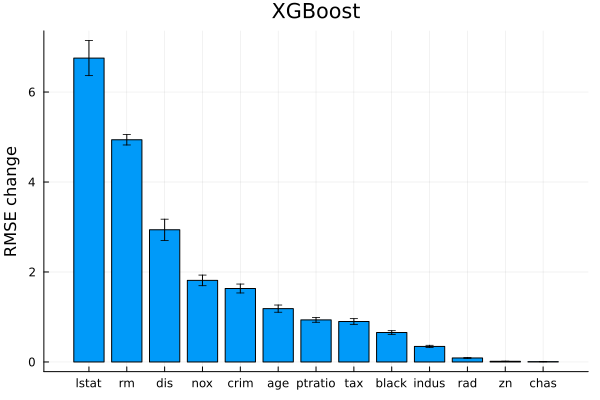

In [16]:
xgb_rmse = RMSE(y, XGBoost.predict(xgb_reg, X))
reps = 20
perm_feat_imp = varimp(houses, xgb_reg, xgb_rmse, reps, 42);
bar(perm_feat_imp.feature,
    perm_feat_imp.rmse_change,
    yerr = perm_feat_imp.rmse_std,
    legend = nothing,
    ylab = "RMSE change", 
    title = "XGBoost")

The outcome is aligned with the XGBoost feature importance, however there is relatively smaller difference between `lstat`, `rm` and less important features.

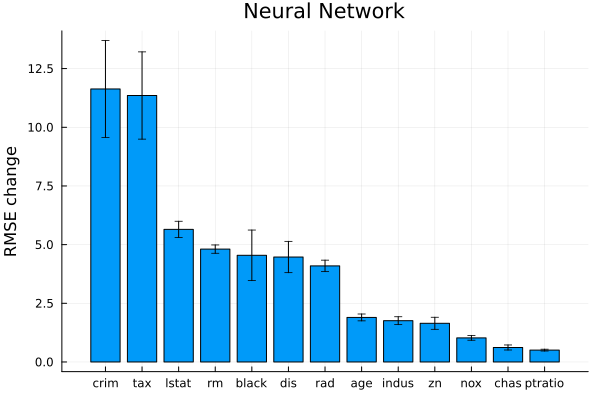

In [17]:
nn_rmse = RMSE(y, transpose(model(X_flux)))
perm_feat_imp = varimp(houses, model, nn_rmse, reps, 42)
bar(perm_feat_imp.feature,
    perm_feat_imp.rmse_change,
    yerr = perm_feat_imp.rmse_std,
    legend = nothing,
    ylab = "RMSE change", 
    title = "Neural Network")

In case of neural network `tax` is by far the most important - the feature was much less important in case of Gradient Boosted Trees.

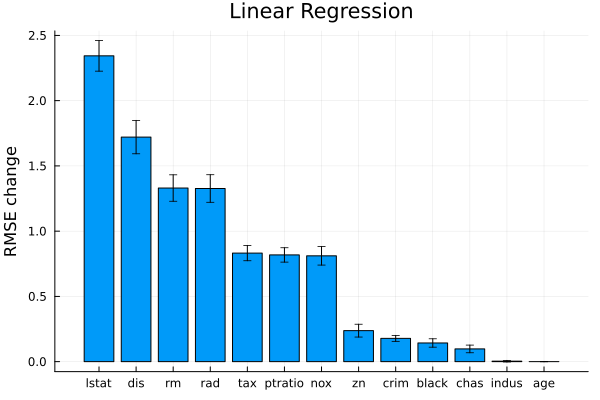

In [18]:
lr_rmse = RMSE(y, GLM.predict(lin_reg, houses))
perm_feat_imp = varimp(houses, lin_reg, lr_rmse, reps, 42)
bar(perm_feat_imp.feature,
    perm_feat_imp.rmse_change,
    yerr = perm_feat_imp.rmse_std,
    legend = nothing,
    ylab = "RMSE change", 
    title = "Linear Regression")

For linear regression `lstat` and `rm` are also important as in the Boosted Trees case, but additionally `dis` is second in terms of RMSE change. 

### SHAP values

**Shapley values** is a concept from the game theory regarding fair distribution of the payout in a game with multiple players. The payout is calculated based on averaged contributions in all possible _coalitions_ (combinations of players taking part in the game). If we switch the notion of a player to a feature and payout to model's prediction the algorithm can be applied to interpret Machine Learning models.

Shapley values are calculated on the prediction (local) level for each feature. The value can be interpreted as average contribution to the prediction compared to mean prediction over the whole dataset. To calculate contributions,  input observation is modified by removing the features  - analogous to absence of the players in a coalition. The predictions over all coalitions (feature combinations)  are gathered and an average 'payout' for each feature is calculated. 

An exact Shapley values calculation is compute-intensive as the number of coalitions increase exponentially with the number of feature, hence an approximate solution in the form of **SHAP values** is often used.

We need to prepare the auxilary prediction function as an input for SHAP values calculation.

In [19]:
function predict_function(model, data)
    if model isa Booster
        prediction = XGBoost.predict(model, Matrix(data))
    elseif model isa StatsModels.TableRegressionModel
        data.medv .= 1
        prediction = GLM.predict(model, data)
    elseif model isa Chain
        prediction = vec(model(transpose(Matrix(data)))) 
    else
        throw(DomainError("Unsupported model"))
    end
    return DataFrame(y_pred = prediction)
end

predict_function (generic function with 1 method)

Calculating SHAP values for the first observation. 1000 random coalitions are tested instead of all combinations. The result from the algorithm is sorted and plotted for easier interpretation.

In [20]:
X = houses[:, Not(:medv)]
observation = DataFrame(houses[1, Not(:medv)])

Row,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98


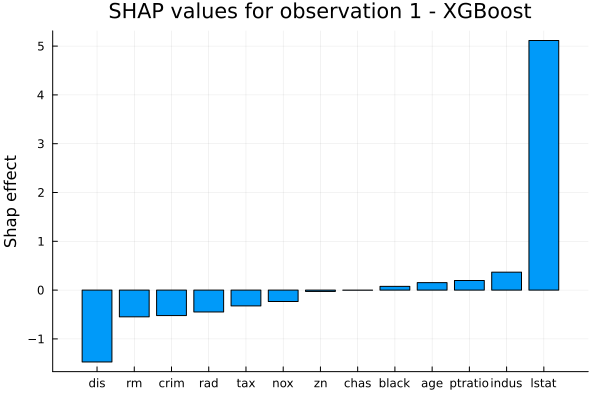

In [21]:
data_shap = ShapML.shap(explain = observation, reference = X, model = xgb_reg,
                        predict_function = predict_function, sample_size = 1000, seed = 1)
sort!(data_shap, :shap_effect)
bar(data_shap.feature_name,
    data_shap.shap_effect,
    legend = nothing,
    ylab = "Shap effect", 
    title = "SHAP values for observation 1 - XGBoost")

`lstat` is by far the most important feature for the first observation. `lstat` value in the analysed observation (4.98) is much lower than the feature's average (12.65) and due to that contributes around 5000$ to the median house value. Such high reliance on the `lstat` may indicate overfitting issue, but a separate holdout set would be needed to verify.

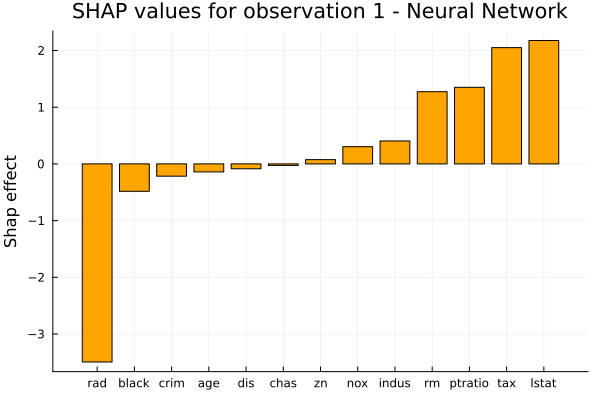

In [23]:
data_shap = ShapML.shap(explain = observation, reference = X, model = model,
                        predict_function = predict_function, sample_size = 1000, seed = 1)
sort!(data_shap, :shap_effect)
bar(data_shap.feature_name,
    data_shap.shap_effect,
    legend = nothing,
    color = "orange",
    ylab = "Shap effect", 
    title = "SHAP values for observation 1 - Neural Network")

For neural network the contribution distribution is different. `lstat` is still important, but `rad` has the highest influence on the prediction.

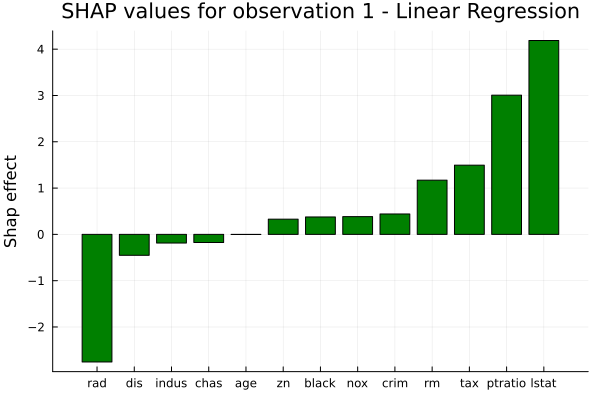

In [25]:
data_shap = ShapML.shap(explain = observation, reference = X, model = lin_reg,
                        predict_function = predict_function, sample_size = 1000, seed = 1)
sort!(data_shap, :shap_effect)
bar(data_shap.feature_name,
    data_shap.shap_effect,
    legend = nothing,
    color = "green",
    ylab = "Shap effect", 
    title = "SHAP values for observation 1 - Linear Regression")

SHAP values for linear regression are somewhere in between results for neural network and boosted trees.

## XAI for unstructured data

We worked only with tabular data so far, but the multitude of novel AI applications use unstructured data such as image and text. In such applications, mainly deep neural networks are used as the shallow models doesn't have sufficient capacity for the task. Hence we may expect a black-box approach whenever dealing with unstructured data. 

Approach feasible for tabular data doesn't fit well for image or text datasets in the context of interpretability. Features can't be easily listed and assigned an importance. For each domain, XAI techniques focus on a specific features - in image recognition relevant pixels (or superpixels) may be highlighted, while in sentiment analysis the words contributing the most to the sentiment prediction.

Some of the interpretability algorithms used on tabular data may be reused for unstructured datasets (e.g. [LIME](https://ema.drwhy.ai/LIME.html)), but there are also methods specific to each domain of the unstructred training. Often the specialised methods leverage the fact that the deep neural networks are based on gradient calculations, see for example [Integrated Gradients](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients) or [SmoothGrad](https://arxiv.org/abs/1706.03825).


We'll use a pretrained image classification model [VGG](https://arxiv.org/abs/1409.1556) on the image of main building of Warsaw School of Economics. After inspecting the classes predicted by the model, we'll utilize [LRP](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140) algorithm to mark the pixels which contributed the most to the obtained prediction.

![](./sgh.jpeg)

A picture we'll use for image classifiation task.

Load the VGG model.

In [29]:
model = VGG(16, pretrain = true).layers;
# model = strip_softmax(flatten_chain(model));

Load the list of Imagenet target classes.

In [31]:
imagenet_classes = CSV.read("imagenet.csv", DataFrame, delim = ';');

Load the input image `sgh.jpeg`.

In [36]:
input = preprocess_imagenet(load("sgh.jpeg"))
input = reshape(input, 224, 224, 3, :);

Sort output classes based on the prediction probability.

In [37]:
best_classes = sortperm(vec(model(input)), rev = true);

Main building of Warsaw School of Economics is classified as palace.

In [38]:
imagenet_classes[best_classes[1], :class_name]

"palace"

Let's see which parts of the picture were important for the prediction (red elements on the heatmap).

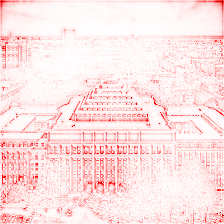

In [39]:
analyzer = LRP(model, EpsilonPlus())
ExplainableAI.heatmap(input, analyzer)

The second pick from the model is a dome - quite accurate.

In [40]:
imagenet_classes[best_classes[2], :class_name]

"dome"

Let's highlight important elements of the photograph again.

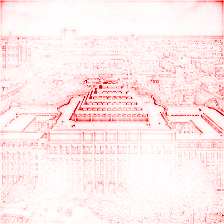

In [41]:
ExplainableAI.heatmap(input, analyzer, best_classes[2])

The third pick is totally off - the closest sea is 250km away.

Let's see why the model predicted that.

In [42]:
imagenet_classes[best_classes[3], :class_name]

"seashore, coast, seacoast, sea-coast"

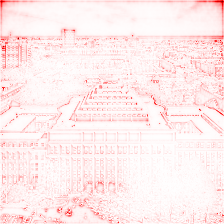

In [43]:
ExplainableAI.heatmap(input, analyzer, best_classes[3])